In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from seiz_eeg.dataset import EEGDataset

import os


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [5]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

from pathlib import Path


data_path = "/home/stnikoli/nml_project/data/"

DATA_ROOT = Path(data_path)

In [6]:
print(data_path)

/home/stnikoli/nml_project/data/


We have train segments, with labels...

In [7]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
display(clips_tr.iloc[100:115])

,label,start_time,end_time,date,sampling_rate,signals_path
id,,,,,,
pqejgcpt_s002_t001_0,0,0.0,12.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_1,0,12.0,24.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_2,0,24.0,36.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_3,0,36.0,48.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_4,0,48.0,60.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_5,0,60.0,72.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_6,0,72.0,84.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_7,0,84.0,96.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_8,0,96.0,108.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet


... and test segments, unlabeled.

In [8]:
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")
display(clips_te.head(10))

,start_time,end_time,date,sampling_rate,signals_path
id,,,,,
pqejgcvm_s001_t000_0,0.0,12.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_1,12.0,24.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_2,24.0,36.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_3,36.0,48.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_4,48.0,60.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_5,60.0,72.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_6,72.0,84.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_7,84.0,96.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_8,96.0,108.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet


The EEG signals are stored in separate files at the corresponding `signals_path`, and each of them contains all data from a given session. Next section illustrate a convenient interface for loading and iterating on data.

In [9]:
clips_tr.shape

(12993, 6)

In [10]:
display(
    pd.read_parquet(DATA_ROOT / "train" / clips_tr.iloc[1992]["signals_path"]).iloc[
        12000:12015
    ]
)

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,FZ,CZ,PZ
12000,146.516575,57.710376,-120.512372,24.751375,18.037504,21.089264,20.784088,8.271874,-39.945924,-37.199341,79.377868,-133.024586,-37.199341,24.751375,51.912033,46.113691,-54.289193,46.113691,-123.258956
12001,146.420203,45.406967,-114.810401,21.298068,20.687716,20.077364,24.044652,9.396207,-35.464657,-36.075008,82.028080,-143.496939,-36.380184,25.570531,53.036366,49.069079,-56.826972,47.543199,-121.524271
12002,121.717014,11.548500,-90.990616,22.229658,27.417649,18.262371,30.164232,3.003574,-18.358742,-44.909049,70.752632,-136.156655,-36.058947,24.060714,52.136900,42.371270,-31.176131,54.273132,-120.287506
12003,126.439210,33.055373,-87.183947,23.289743,26.646678,17.491400,28.782910,2.842955,-19.740065,-46.290371,62.352263,-131.739634,-42.628260,22.679391,45.567586,37.938188,-30.116047,52.586633,-121.974004
12004,111.855013,40.138667,-112.449303,27.626453,20.302231,25.795398,23.048814,14.503888,-32.493207,-31.577679,74.013196,-133.506442,-42.258837,23.964342,51.125001,52.345705,-46.531300,50.819825,-116.721766
12005,123.515946,19.145775,-102.619425,29.826933,23.723414,28.606229,22.807886,16.094015,-37.922126,-33.649663,65.532517,-138.019834,-41.889413,30.437284,49.358193,56.377239,-50.739515,55.766887,-116.352342
12006,116.143538,16.961357,-106.329722,28.558043,23.370052,24.590756,27.642515,9.637135,-20.880459,-39.496191,67.620563,-137.457668,-43.158303,24.590756,44.732368,50.225535,-28.204682,58.160109,-116.705704
12007,107.759230,32.685949,-102.812168,28.718662,20.173736,22.920319,27.497958,6.745994,-14.921497,-41.166628,64.729423,-133.024586,-47.575323,18.037504,43.672283,45.198163,-21.330192,60.456960,-117.765789
12008,110.505814,39.094644,-108.610511,30.854894,21.699615,28.718662,23.530671,13.459865,-30.790646,-35.978637,64.119071,-132.109058,-43.608036,25.056551,47.944746,51.606858,-43.913211,55.268969,-116.850261
12009,109.734843,34.051210,-129.523093,31.304627,16.351006,32.220154,20.623469,18.182061,-39.191015,-31.256441,77.386193,-133.490381,-37.665136,28.558043,49.615183,58.770461,-51.398053,58.465285,-112.738417


## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [11]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

In [ ]:
# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_te,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

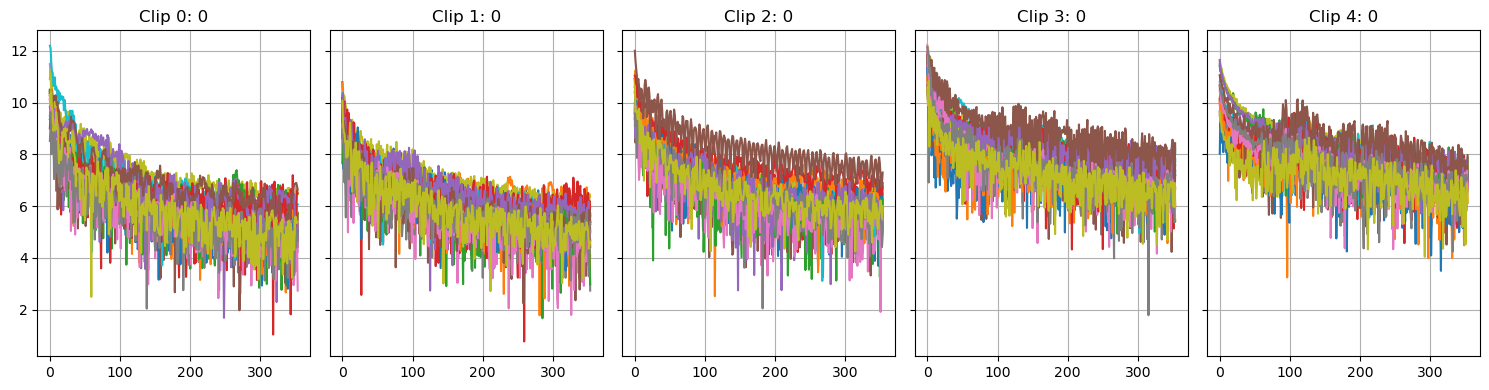

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, (x, y) in enumerate(dataset_tr):
    if i > 4:
        break
    axes[i].plot(x)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()

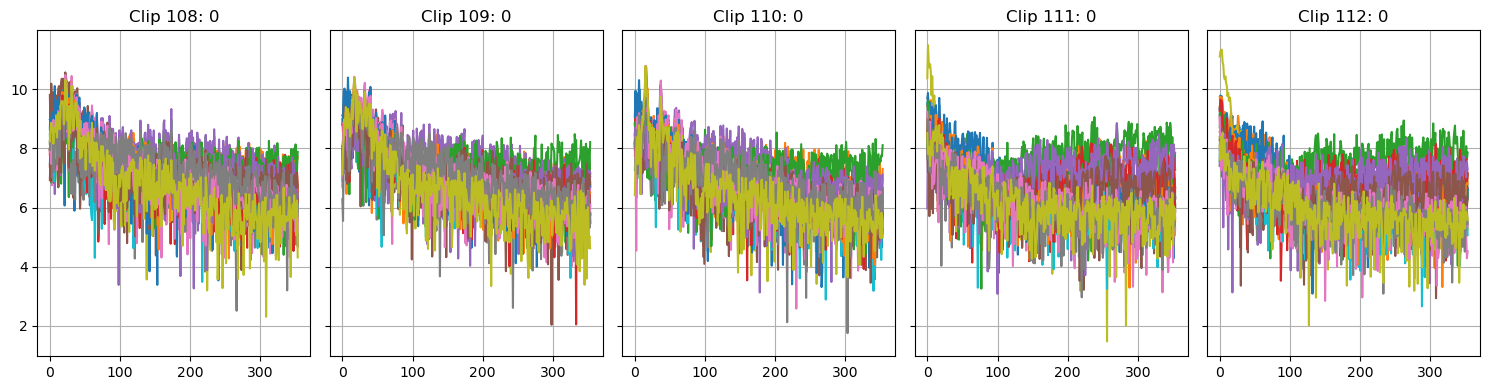

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, ax in zip(range(108, 113), axes):
    x, y = dataset_tr[i]
    ax.plot(x)
    ax.grid()
    ax.set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [16]:
# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [17]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [18]:
loader_tr = DataLoader(dataset_tr, batch_size=512, shuffle=True)

In [19]:
for x, y in loader_tr:
    print(x.shape)
    print(y.shape)
    break

torch.Size([512, 354, 19])
torch.Size([512])


## Baseline: LSTM model for sequential data

In this section, we provide a simple baseline for the project using an LSTM model without any special optimization.

In [20]:
# Define the model
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=19, hidden_dim=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, 1)  # Output for binary classification

    def forward(self, x):
        """
        x shape: [batch_size, seq_len, input_dim]
        """
        out, (h_n, c_n) = self.lstm(x)  # out shape: [batch_size, seq_len, hidden_dim]
        last_timestep = out[:, -1, :]  # [batch_size, hidden_dim]
        logits = self.fc(last_timestep)  # [batch_size, 1]
        return logits

In [21]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [22]:
# Instantiate model, loss, and optimizer, then move model to device
model = SimpleLSTM(input_dim=19, hidden_dim=64, num_layers=3, dropout=0.3).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [23]:
# Training loop
num_epochs = 1000
train_losses = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        # Move data to GPU (if available)
        x_batch = x_batch.float().to(device)  # [batch_size, seq_len, input_dim]
        y_batch = y_batch.float().unsqueeze(1).to(device)  # [batch_size, 1]

        # Forward pass
        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader_tr)
    train_losses.append(avg_loss)

Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:30<00:00,  4.74it/s]


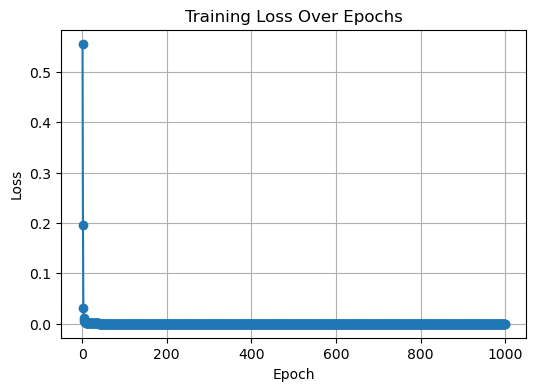

In [24]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Submission

In [30]:
# Create test dataset
dataset_te = EEGDataset(
    clips_te,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=fft_filtering,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [44]:
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.
        x_batch, x_ids = batch

        # Move the input data to the device (GPU or CPU)
        x_batch = x_batch.float().to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x_batch)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = (logits > 0).int().cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

def remove_underlines(s):
    s = s.replace("___", "###")
    s = s.replace("_", "")
    s = s.replace("###", "_")
    return s

corrected_ids = [remove_underlines(i) for i in all_ids]
# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": corrected_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
